# A self-inflicted tutorial on sampling schemes
Following notes available at: 
 * [Tutorial by Andrieu et. al. ](http://www.cs.ubc.ca/~arnaud/andrieu_defreitas_doucet_jordan_intromontecarlomachinelearning.pdf 'An introduction to MCMC for Machine Learning')


In [1]:
from __future__ import print_function
import torch
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np 
from scipy.stats import multivariate_normal as mv
from scipy.stats import norm
%matplotlib inline
import matplotlib.mlab as mlab
import matplotlib.cm as cm
from sklearn import mixture

In [2]:
# Calculate pdf (normalized) for x, mean m and stdev s 
# If x is an 1-dim array, should use 1D

# Bimodal uses scipy and is normalized
gauss_1D = lambda x,m,s: norm.pdf(x,loc=m,scale=s)
# np.exp(-(x - m)**2/(2 * s**2)) / (s*np.sqrt(np.pi*2))
# Uncomment above for un-normalized

gauss_2D = lambda x,m,sigma: mv.pdf(x,m,sigma)

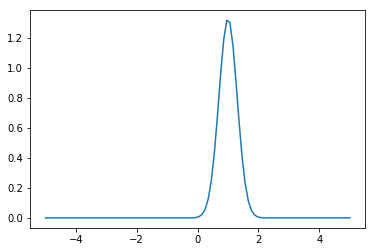

In [3]:
# Test 1D 
n = np.linspace(-5,5,100)
res = gauss_1D(n,1,0.3)
plt.plot(n,res);

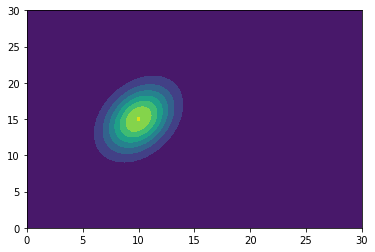

In [4]:
# Test 2D
n = np.linspace(0,30,100)
m = np.linspace(0,30,100)
x,y = np.meshgrid(n,m)
# Scipy needs a third axis, hence the use of dstack
pos = np.dstack((x, y))
cov_indepedent = [[4,0],[0,9]]
cov_mixed = [[4,2],[2,9]]
#plot the pdf for independent normals
res2 = gauss_2D(pos,[10,15],cov_mixed)
plt.contourf(x,y,res2);

## Gaussian Mixture Models
- 1D 

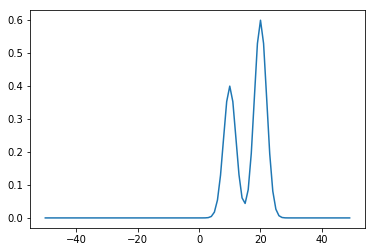

In [5]:
n = np.arange(-50,50)
res_mixed= 2* gauss_1D(n,10,2) + 3*gauss_1D(n,20,2)
plt.plot(n,res_mixed);

The workflow for **2D** is the following:
   - Generate a gaussian mixture model by calculating pdfs 
   - Sample from the gmm using your *favourite* sampling scheme
   - Plot the gmm together with the samples 

In [6]:
def gmm(x,y,mu1,mu2,cov1,cov2):
    pos = np.dstack((x,y))
    g1 = gauss_2D(pos,mu1,cov1)
    g2 = gauss_2D(pos,mu2,cov2)
    return (2*g1 + 3*g2)/5

# Covariances and means
mu1 = [-1,-1]
mu2 = [1,2]
cov1 = [[1,-0.8],[-0.8,1]]
cov2 = [[1.5,0.6],[0.6,0.8]]

# Metropolis Hastings MCMC
The goal is to sample correctly from the target distribution $p(x)$ defined as GMM here. Ingredients:
* A proposal $q(x^*|x)$ here taken to be $x^* \sim N(x,\sigma)$
* Accept $x^*$ with $min\{1,\frac{p(x^*)q(x|x^*)}{p(x)q(x^*|x)}\}$
* More specifically, if $(U(0,1) < acc)$ then $x = x^*$

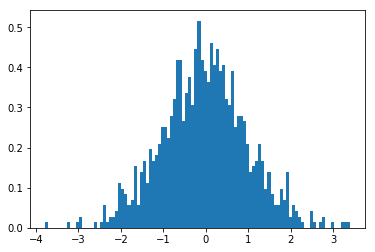

In [7]:
# Just fooling around
samp = [] 
for i in range(1000):
    samp.append(np.random.normal())
plt.hist(samp, bins=100, normed=True);

In [50]:
def metropolis_hastings(N,burnin):
    # Initial sample
    x = np.zeros(2)
    r = np.zeros(2)
    # Compute p(x_initial) = p(x)
    p = gmm(x[0],x[1],mu1,mu2,cov1,cov2)
    p1 = gmm(x[0],x[1],mu1,mu2,cov1,cov2)
    
    samples = []
    samples1 = []
    acc = 0
    acc_ratio = []
    # Collect every 10th sample 
    for i in range(N):
        # Propose x^* ~ q(x*|x) = N(x,1) = x + N(0,1) * 1
        #x_star = np.random.normal(loc = x,scale =1,size=2)
        x_star = x + np.random.normal(size=2)
        rn = r + np.random.normal(size=2)
        
        # Compute p(x^*)
        pn = gmm(rn[0],rn[1],mu1,mu2,cov1,cov2)
        p_star = gmm(x_star[0],x_star[1],mu1,mu2,cov1,cov2)
        
        # Compute pdf q(x|x*).pdf
        q = gauss_2D(x,x_star,1)
        
        # Compute q(x^*|x).pdf 
        q_star = gauss_2D(x_star,x,1)
        
        # Accept or reject using U(0,1)
        u = np.random.rand()
        if pn >=p1:
            p1 = pn
            r = rn
        elif u < pn/p1: 
            p1 = pn
            r = rn
            
        ratio = (p_star * q)/(p * q_star)
        if u < min(1,ratio): 
            x = x_star
            p = p_star
            acc +=1
            acc_ratio.append(acc/(i+1))
            
        # keep every 10th sample
        if i % 10==0:  
            samples.append(x)
            samples1.append(r)

    return [samples, samples1, acc_ratio]

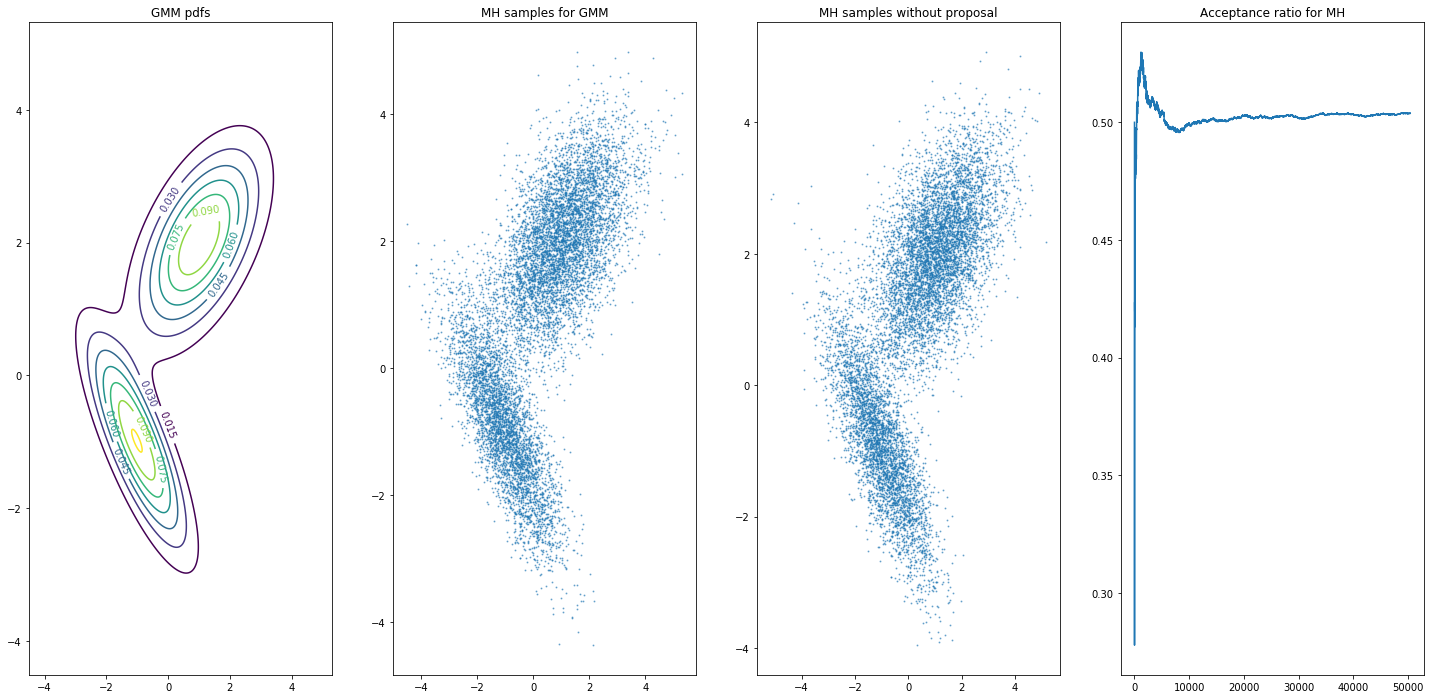

In [51]:
# Sample from the gmm using 
'''Metropolis Hastings'''
[samples,samples1,acc_ratio] = metropolis_hastings(N = 100000, burnin = 10)

n = np.linspace(np.min(samples),np.max(samples),1000)
m = np.linspace(np.min(samples),np.max(samples),1000)
x,y = np.meshgrid(n,m)

fig, ax = plt.subplots(1, 4, figsize=(25,12))

# Compute PDFs
z = gmm(x,y,mu1,mu2,cov1,cov2)

# Plot target distribution (gmm) and MH samples together
samples = np.array(samples)
samples1 = np.array(samples1)
acc_ratio = np.array(acc_ratio)
ax[1].scatter(samples[:, 0], samples[:, 1], alpha=0.5, s=1)
ax[1].set_title('MH samples for GMM')
ax[3].plot(acc_ratio)
ax[3].set_title('Acceptance ratio for MH')

ax[2].scatter(samples1[:,0],samples1[:,1],alpha=0.5, s=1)
ax[2].set_title('MH samples without proposal')

CS = ax[0].contour(x,y,z);
ax[0].clabel(CS, inline=1, fontsize=10)
ax[0].set_title('GMM pdfs');

**After fitting the GMM, my samples are marginally better**

** For finite model selection you can use Bayesian or Akaike information criterion - BIC, AIC** 

**To do**: Autocorrelation - but you need a different example, won't work for this one.


In [62]:
mix = mixture.GaussianMixture(n_components=2, covariance_type='full')
mix.fit(samples)
mix1 = mixture.GaussianMixture(n_components=2, covariance_type='full')
mix1.fit(samples1)

print('MH samples mean and covariance using proposal:\n {0}\n {1}'.format(mix.means_, mix.covariances_))
print('MH samples mean and covariance with symmetric proposal:\n {0}\n {1}'.format(mix1.means_, mix1.covariances_))

MH samples mean and covariance using proposal:
 [[-1.02234508 -0.97688547]
 [ 1.0057447   2.00313689]]
 [[[ 0.94280584 -0.75142516]
  [-0.75142516  0.95939504]]

 [[ 1.43205407  0.58168272]
  [ 0.58168272  0.80324818]]]
MH samples mean and covariance with symmetric proposal:
 [[-1.0410786  -0.94620254]
 [ 1.02972268  2.02354303]]
 [[[ 0.96570114 -0.77126064]
  [-0.77126064  0.97580652]]

 [[ 1.40475247  0.5368864 ]
  [ 0.5368864   0.75580987]]]


# Rejection sampling
* Main and **very crucial** question: **How do you choose M and the proposal q?**
    - Especially since you don't know how to bound p (q has to essentially bound p) 
* Main condition: For $u \sim U(0,1)$ and $M$ a scaling constant, the proposal distribution satifies:
    * $ u * M * q(x^{i}) < p(x^i)$
* We'll say $q = N(0,1)$ and $M = 2$ and stop when we have 1000 accepted samples. We'll plot the ratio as before.   
* It suffers from a main limitation, that in high dimensional space, the acceptance probability scales inversely with M - which means if M is large, you accept very little samples

In [28]:
def rejection_sampling(N, M):
    acc = 0
    samples = []
    iterations = 0  
    acc_ratio = []
    
    # Collect all samples that are accepted, no burn-in here
    while acc<N:
        
        # Sample from N(0,1) - could try N(x_previous,1) or something totally  different
        x = np.random.normal(loc=0,scale=2,size=2)
        
        # Sample u ~ U(0,1)
        u = np.random.rand()
        # Compute p(x) and q(x,0,1)
        p = gmm(x[0],x[1],mu1,mu2,cov1,cov2)
        q = gauss_2D(x,[0,0],2)
        #print(x,p,q)
        if u < p/(M * q):
            samples.append(x)
            acc+=1
            if acc%1000== 0:
                print('{0} samples accepted'.format(acc))
        
        iterations+=1
        acc_ratio.append(acc/iterations)
    
    return [samples, acc_ratio]

1000 samples accepted
2000 samples accepted
3000 samples accepted
4000 samples accepted
5000 samples accepted
6000 samples accepted
7000 samples accepted
8000 samples accepted
9000 samples accepted
10000 samples accepted


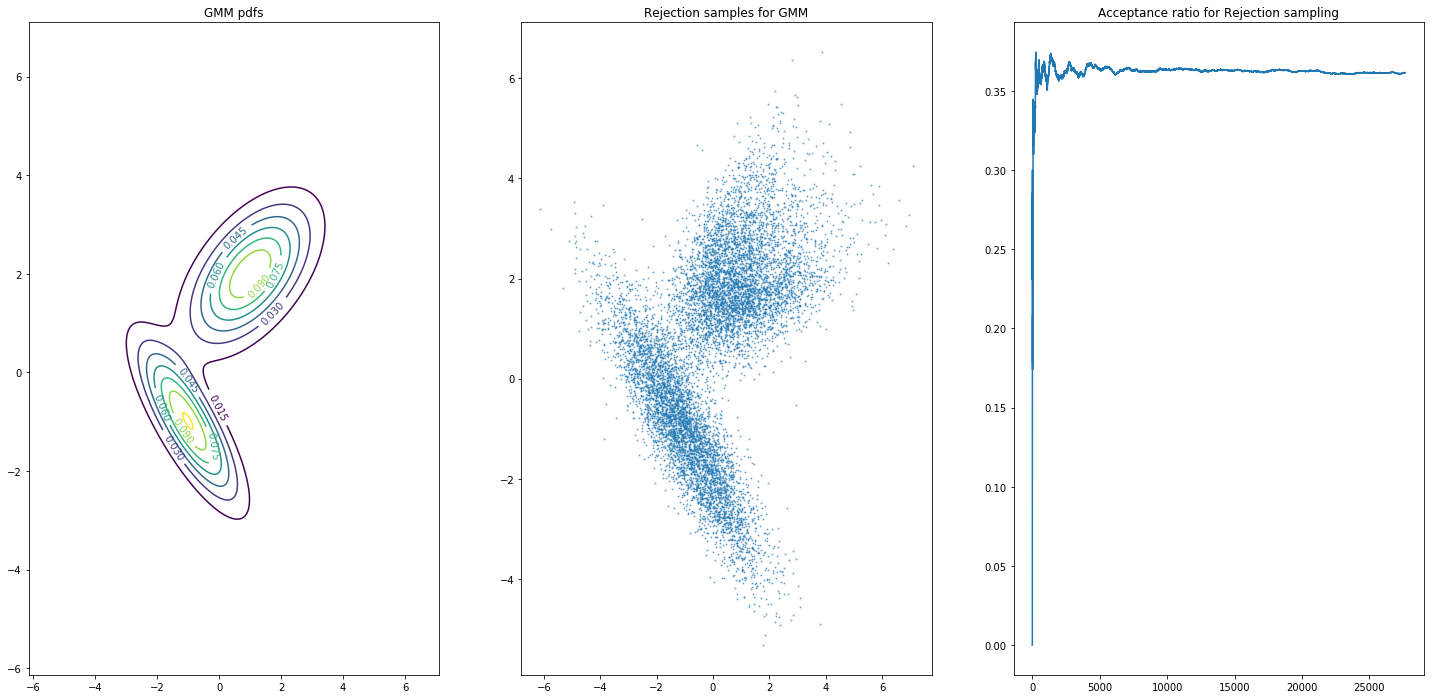

In [30]:
# Sample from the gmm using 
'''Rejection sampling'''
[samples,acc_ratio] = rejection_sampling(N = 10000, M = 2)

n = np.linspace(np.min(samples),np.max(samples),1000)
m = np.linspace(np.min(samples),np.max(samples),1000)
x,y = np.meshgrid(n,m)

fig, ax = plt.subplots(1, 3, figsize=(25,12))

# Compute PDFs
z = gmm(x,y,mu1,mu2,cov1,cov2)

# Plot target distribution (gmm) and rejection samples together
samples = np.array(samples)
acc_ratio = np.array(acc_ratio)

CS = ax[0].contour(x,y,z);
ax[0].clabel(CS, inline=1, fontsize=10)
ax[0].set_title('GMM pdfs');

ax[1].scatter(samples[:, 0], samples[:, 1], alpha=0.5, s=1);
ax[1].set_title('Rejection samples for GMM')
ax[2].plot(acc_ratio)
ax[2].set_title('Acceptance ratio for Rejection sampling');

# Importance sampling - Buggy 
# Sampling importance re-sampling
* Simple idea, put more importance in sampling from regions of high density. Sounds ideal. 
* Rewrite $p(x) = w(x) * q(x)$. ** Again choice of q is done such that variance of the estimator is minimized. (what about bias?)** 
* Minimize $\Sigma_q(x)[f^2(x)w^2(x)]$ and after applying Jensen's inequality you get that the optimal q is lower bounded by:
    * $q^*(x) \propto |f(x)| p(x)$ 
    * This is all in the context of calculating expectations for $f(x)$ of course. It tells you that "efficient sampling occurs when you   focus on sampling from $p(x)$ in the important regions where $|f(x)| p(x)$ is high". Turns out you can have situations where sampling from $q^*(x)$ can be more beneficial than sampling from $p(x)$ directly. Where you need to calculate expectations/integrals w.r.t $p(x)$
* Note that AIS (Adaptive importance sampling) performs well in the case of the Boltzmann Machines when it comes to evaluating the partition function    
* **Update**: Two days later and 10 tutorials that have no examples, Michael Jordan enlightens me once again.." However, we do not directly get samples from p(x). To get samples from p(x), we must sample from the weighted sample from our importance
sampler. This process is called Sampling Importance Re-sampling (SIR)" 
** Because for some fucking reason everyone wants to calculate integrals. NO, it shouldn't be the case, an introductory thing should cover just the sampling part even if that's more complicated than the integral!!!!" **

In [95]:
a = np.ones(100,)
b = np.zeros((2,100))
np.dot(b,a)

array([0., 0.])

In [102]:
def importance_sampling(N):
    i = 1
    samples = []
    w = 0
    normalized_w = 0 
    q = np.zeros(100)
    # Collect all samples that are accepted, no burn-in here
    while i<=N:
        
        # Sample from N(0,1) - could try N(x_previous,1) or something totally  different
        x = np.random.normal(loc=0,scale=2,size=(2,100))
        
        # Compute p(x) and q(x,0,1)
        p = gmm(x[0,:],x[1,:],mu1,mu2,cov1,cov2)
        for j in range(100):
            q[j] = gauss_2D(x[:,j],[0,0],2)
        # use w(x_i) as estimate for p(x_i) = w(x_i) * q(x_i)
        
        # Re-sample x with prob proportional to normalized_w 
        w = p/q  
        #print(x.shape)
        #print(w.shape)
        val = np.dot(x,w)
        normalized_w = val/100
        #u = np.random.rand()
        #if (u < w):
        samples.append(normalized_w)
        i+=1

    return samples

In [ ]:
# Sample from the gmm using 
'''Importance sampling'''
samples = importance_sampling(N = 500)

n = np.linspace(np.min(samples),np.max(samples),1000)
m = np.linspace(np.min(samples),np.max(samples),1000)
x,y = np.meshgrid(n,m)

fig, ax = plt.subplots(1, 2, figsize=(25,12))

# Compute PDFs
z = gmm(x,y,mu1,mu2,cov1,cov2)

# Plot target distribution (gmm) and importance samples together
samples = np.array(samples)

CS = ax[0].contour(x,y,z);
ax[0].clabel(CS, inline=1, fontsize=10)
ax[0].set_title('GMM pdfs');

ax[1].scatter(samples[:, 0], samples[:, 1], alpha=0.5, s=1);
ax[1].set_title('Importance samples for GMM');
#ax[2].plot(acc_ratio)
#ax[2].set_title('Acceptance ratio for Importance sampling');

# Hamiltonian Monte Carlo

# Gibbs sampling

See RBM 